In [1]:
import backtrader as bt
import datetime
import yfinance as yf
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])
%matplotlib inline

In [2]:
# Create a Stratey
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] < self.dataclose[-1]:
                    # current close less than previous close

                    if self.dataclose[-1] < self.dataclose[-2]:
                        # previous close less than the previous close

                        # BUY, BUY, BUY!!! (with default parameters)
                        self.log('BUY CREATE, %.2f' % self.dataclose[0])

                        # Keep track of the created order to avoid a 2nd order
                        self.order = self.buy()

        else:

            # Already in the market ... we might sell
            if len(self) >= (self.bar_executed + 5):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

In [13]:
cerebro = bt.Cerebro()

In [14]:
df = yf.download('MSFT', start='2010-01-01')

[*********************100%***********************]  1 of 1 completed


In [15]:
cerebro.adddata(bt.feeds.PandasData(dataname=df))

In [16]:
cerebro.addstrategy(TestStrategy)

0

In [17]:
cerebro.run()

2009-12-31, Close, 30.48
2009-12-31, BUY CREATE, 30.48
2010-01-04, BUY EXECUTED, Price: 30.62, Cost: 30.62, Comm 0.00
2010-01-04, Close, 30.95
2010-01-05, Close, 30.96
2010-01-06, Close, 30.77
2010-01-07, Close, 30.45
2010-01-08, Close, 30.66
2010-01-11, Close, 30.27
2010-01-11, SELL CREATE, 30.27
2010-01-12, SELL EXECUTED, Price: 30.15, Cost: 30.62, Comm 0.00
2010-01-12, OPERATION PROFIT, GROSS -0.47, NET -0.47
2010-01-12, Close, 30.07
2010-01-12, BUY CREATE, 30.07
2010-01-13, BUY EXECUTED, Price: 30.26, Cost: 30.26, Comm 0.00
2010-01-13, Close, 30.35
2010-01-14, Close, 30.96
2010-01-15, Close, 30.86
2010-01-19, Close, 31.10
2010-01-20, Close, 30.59
2010-01-21, Close, 30.01
2010-01-21, SELL CREATE, 30.01
2010-01-22, SELL EXECUTED, Price: 30.00, Cost: 30.26, Comm 0.00
2010-01-22, OPERATION PROFIT, GROSS -0.26, NET -0.26
2010-01-22, Close, 28.96
2010-01-22, BUY CREATE, 28.96
2010-01-25, BUY EXECUTED, Price: 29.24, Cost: 29.24, Comm 0.00
2010-01-25, Close, 29.32
2010-01-26, Close, 29.50


2019-01-15, BUY EXECUTED, Price: 102.51, Cost: 102.51, Comm 0.00
2019-01-15, Close, 105.01
2019-01-16, Close, 105.38
2019-01-17, Close, 106.12
2019-01-18, Close, 107.71
2019-01-22, Close, 105.68
2019-01-23, Close, 106.71
2019-01-23, SELL CREATE, 106.71
2019-01-24, SELL EXECUTED, Price: 106.86, Cost: 102.51, Comm 0.00
2019-01-24, OPERATION PROFIT, GROSS 4.35, NET 4.35
2019-01-24, Close, 106.20
2019-01-25, Close, 107.17
2019-01-28, Close, 105.08
2019-01-29, Close, 102.94
2019-01-29, BUY CREATE, 102.94
2019-01-30, BUY EXECUTED, Price: 104.62, Cost: 104.62, Comm 0.00
2019-01-30, Close, 106.38
2019-01-31, Close, 104.43
2019-02-01, Close, 102.78
2019-02-04, Close, 105.74
2019-02-05, Close, 107.22
2019-02-06, Close, 106.03
2019-02-06, SELL CREATE, 106.03
2019-02-07, SELL EXECUTED, Price: 105.19, Cost: 104.62, Comm 0.00
2019-02-07, OPERATION PROFIT, GROSS 0.57, NET 0.57
2019-02-07, Close, 105.27
2019-02-07, BUY CREATE, 105.27
2019-02-08, BUY EXECUTED, Price: 104.39, Cost: 104.39, Comm 0.00
201

<IPython.core.display.Javascript object>


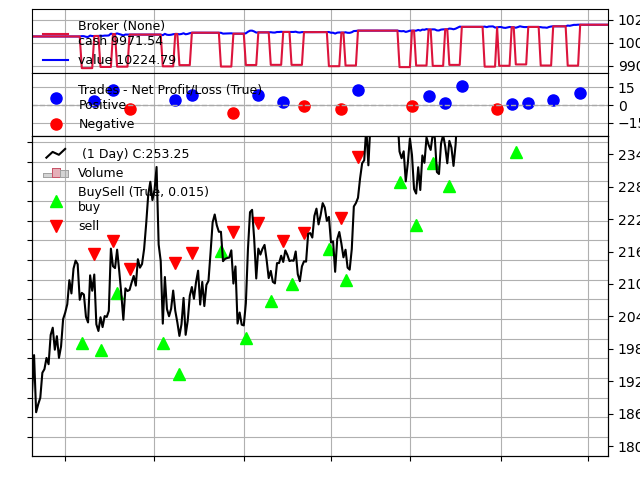

[[<Figure size 640x480 with 4 Axes>]]

In [18]:
cerebro.plot()